# Amazon Link Prediction

# Link Prediction

Definition: Link Prediction focuses on predicting the existence or probability of connections (links) between nodes in a graph. Its goal is to determine whether two nodes will be connected in the future or if an unobserved relationship exists in the graph.

Applications: Link Prediction is used in various applications, such as social networks to predict future friendships, recommendation systems to suggest new connections between users, and in biology to anticipate interactions between proteins, among others.


In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Amazon
import torch_geometric.transforms as T
from torch_geometric.nn import GATv2Conv, GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils import degree
from collections import Counter
import networkx as nx
from random import randint

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"

In [4]:
print(device)

cpu


# EDA

In [5]:
# load the Amazon dataset
dataset = 'Photo'
path = osp.join('.', 'data', dataset)
dataset = Amazon(path, dataset, transform=T.NormalizeFeatures()) # Row-normalize the attributes given in `attrs`.
data = dataset[0]
print(dataset.data)

Processing...


Data(x=[7650, 745], edge_index=[2, 238162], y=[7650])


Done!


In [6]:
import pandas as pd
import os.path as osp
import torch_geometric.transforms as T
from torch_geometric.datasets import Amazon

# Load the Amazon dataset
dataset_name = 'Photo'
path = osp.join('.', 'data', dataset_name)
dataset = Amazon(path, dataset_name, transform=T.NormalizeFeatures())
data = dataset[0]

# Convert edge_index to DataFrame
source_nodes = data.edge_index[0].cpu().numpy()
target_nodes = data.edge_index[1].cpu().numpy()

df_edges = pd.DataFrame({'source': source_nodes, 'target': target_nodes})

print(df_edges)

        source  target
0            0    1210
1            0    2198
2            0    2239
3            0    3152
4            0    3578
...        ...     ...
238157    7648    7566
238158    7648    7630
238159    7649    2239
238160    7649    3295
238161    7649    4196

[238162 rows x 2 columns]


Información general del grafo

In [7]:
#Cantidad de nodos por grado
node_degrees = Counter(degree(data.edge_index[0]).numpy())

In [8]:
sorted(node_degrees.items()) # Organización por numero de grados de menor a mayor

[(0.0, 115),
 (1.0, 173),
 (2.0, 205),
 (3.0, 238),
 (4.0, 219),
 (5.0, 192),
 (6.0, 204),
 (7.0, 222),
 (8.0, 205),
 (9.0, 212),
 (10.0, 184),
 (11.0, 175),
 (12.0, 178),
 (13.0, 153),
 (14.0, 151),
 (15.0, 151),
 (16.0, 161),
 (17.0, 143),
 (18.0, 149),
 (19.0, 140),
 (20.0, 117),
 (21.0, 124),
 (22.0, 136),
 (23.0, 111),
 (24.0, 125),
 (25.0, 114),
 (26.0, 140),
 (27.0, 101),
 (28.0, 138),
 (29.0, 102),
 (30.0, 123),
 (31.0, 112),
 (32.0, 126),
 (33.0, 116),
 (34.0, 112),
 (35.0, 117),
 (36.0, 114),
 (37.0, 106),
 (38.0, 103),
 (39.0, 89),
 (40.0, 89),
 (41.0, 104),
 (42.0, 76),
 (43.0, 77),
 (44.0, 65),
 (45.0, 54),
 (46.0, 47),
 (47.0, 61),
 (48.0, 41),
 (49.0, 50),
 (50.0, 34),
 (51.0, 32),
 (52.0, 43),
 (53.0, 35),
 (54.0, 20),
 (55.0, 35),
 (56.0, 27),
 (57.0, 27),
 (58.0, 23),
 (59.0, 28),
 (60.0, 24),
 (61.0, 15),
 (62.0, 21),
 (63.0, 26),
 (64.0, 21),
 (65.0, 23),
 (66.0, 21),
 (67.0, 13),
 (68.0, 14),
 (69.0, 11),
 (70.0, 16),
 (71.0, 20),
 (72.0, 17),
 (73.0, 11),
 (74.0, 

<BarContainer object of 248 artists>

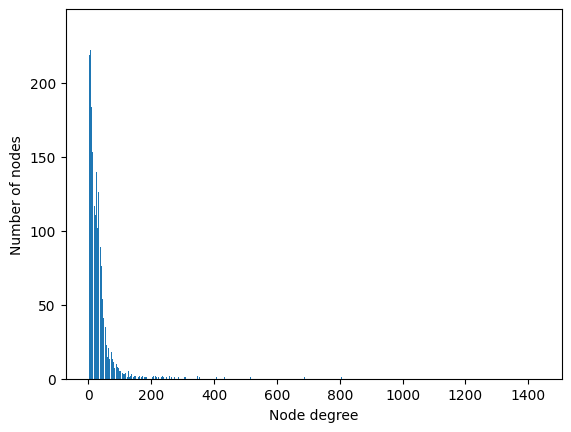

In [ ]:
# Get list of degrees for each node
degrees = degree(dataset[0].edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [9]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('---------------')
print(f'Numero de grafos: {len(dataset)}')
print(f'Cantidad de Nodos: {data.x.shape[0]}')
print(f'Cantidad de features: {dataset.num_features}')
print(f'Cantidad de clases: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Se tienen links dirigidos: {data.is_directed()}')
print(f'Grafo tiene nodos aislados: {data.has_isolated_nodes()}')
print(f'Cantidad de nodos aislados: {node_degrees[0]}')
print(f'Cantidad de nodos con grado = 1: {node_degrees[1]}')
print(f'Grafo tiene self-loops: {data.has_self_loops()}')

Dataset: AmazonPhoto()
---------------
Numero de grafos: 1
Cantidad de Nodos: 7650
Cantidad de features: 745
Cantidad de clases: 8

Graph:
------
Se tienen links dirigidos: False
Grafo tiene nodos aislados: True
Cantidad de nodos aislados: 115
Cantidad de nodos con grado = 1: 173
Grafo tiene self-loops: False


In [ ]:
G = nx.from_pandas_edgelist(df_edges, "source", "target")

In [ ]:
plot_options = {
    'node_size': 50,
    'node_color': 'blue',
    'edge_color': 'gray',
    'alpha': 0.6,
    'width': 0.5,
    'with_labels': False,
}

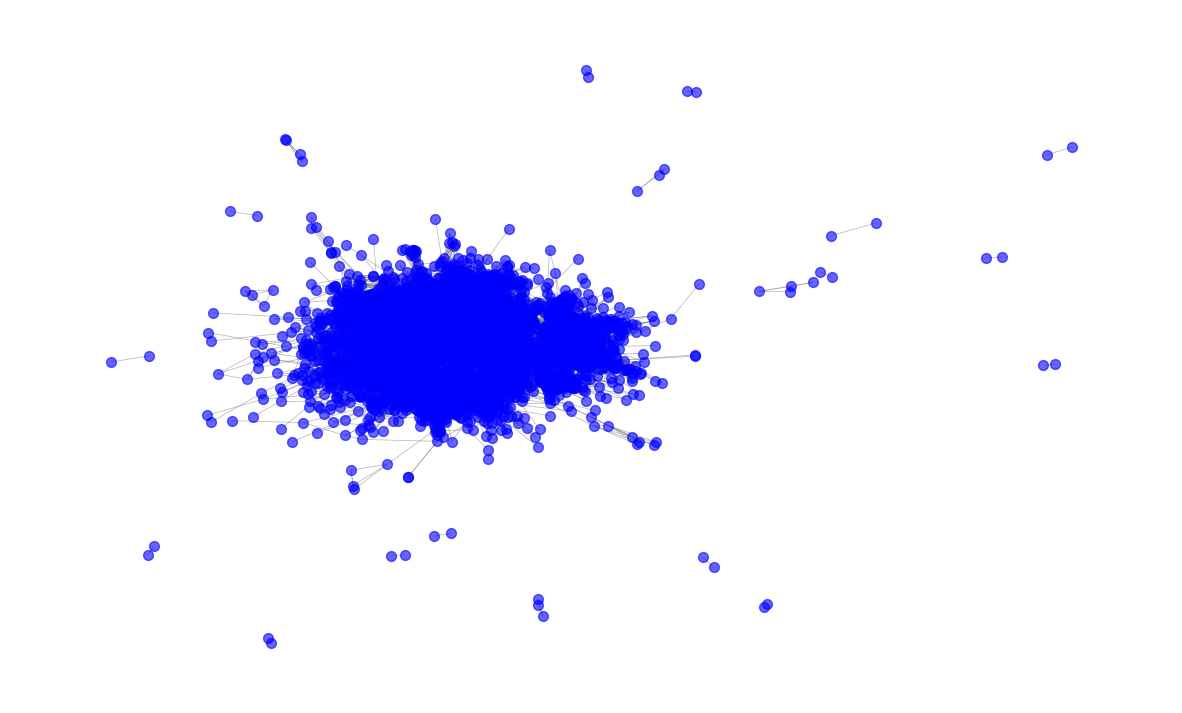

In [ ]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [ ]:
degree_centrality = nx.centrality.degree_centrality(
    G
)  # save results in a variable to use again
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

(sorted(G.degree, key=lambda item: item[1], reverse=True))[:8]

[(2, 1434),
 (3, 997),
 (468, 956),
 (51, 928),
 (302, 806),
 (53, 717),
 (290, 699),
 (57, 688)]

Text(0, 0.5, 'Counts')

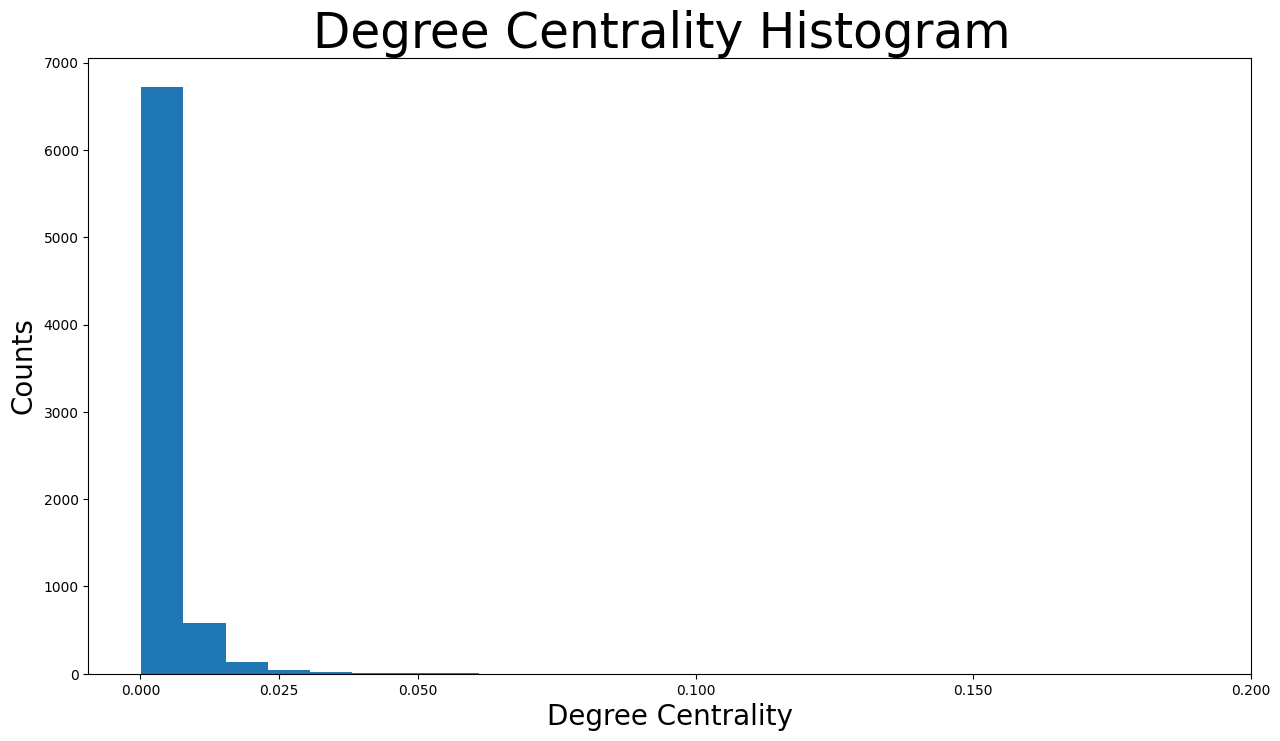

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-0.7158793023228646,
 1.1630473545193674,
 -1.119525247812271,
 1.0323228180408477)

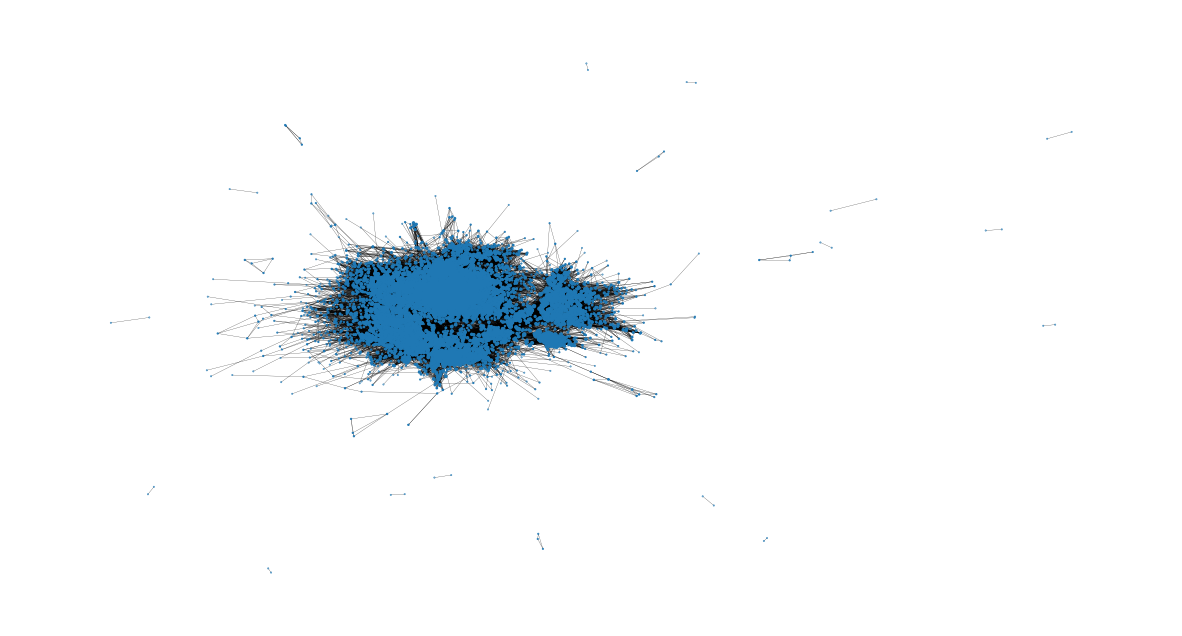

In [ ]:
node_size = [
    v * 1000 for v in degree_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

Centralidad de intermediación

In [ ]:
betweenness_centrality = nx.centrality.betweenness_centrality(
    G
)  # save results in a variable to use again
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  # set the x axis ticks
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

In [ ]:
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

Colors

In [ ]:
G = nx.convert_node_labels_to_integers(G)
# Asegúrate de que todos los nodos tienen un índice en el rango esperado
assert all(0 <= node < G.number_of_nodes() for node in G.nodes()), "Nodo fuera del rango esperado"

In [ ]:
colors = ["" for x in range(G.number_of_nodes())]  # initialize colors list
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    counter += 1
    for node in list(
        com
    ):  # fill colors list with the particular color for the community nodes
        colors[node] = color
counter

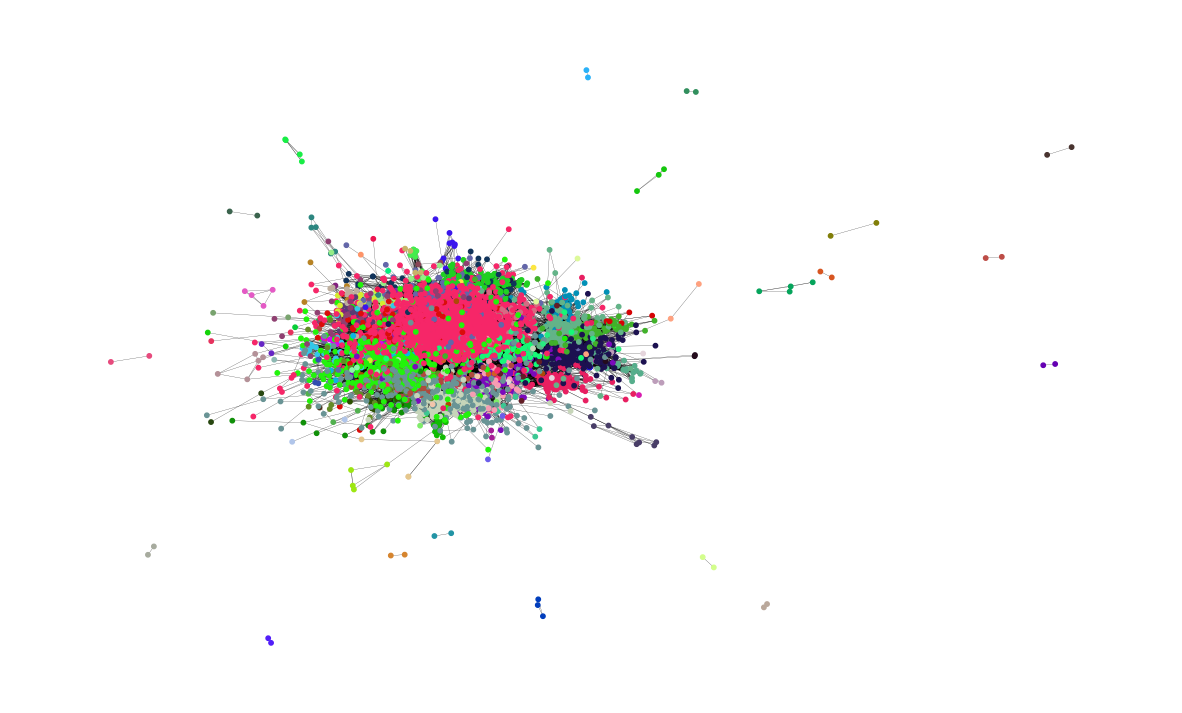

In [ ]:
# Después de renombrar los nodos con `convert_node_labels_to_integers()`
pos = nx.spring_layout(G, iterations=15, seed=1721)

plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)

# **Pre procesamiento**

In [10]:
# use train_test_split_edges to create neg and positive edges
data.train_mask = data.val_mask = data.test_mask = data.y = None
#Retorna mismo dataset con argumentos diferentes train_pos_edge_index= clase positiva de los ejes, test_pos_edge_index ejes de test de clase positiva, train_neg_adj_mask matriz de adyacencia, esta sera la que se samplea
data = train_test_split_edges(data)
print(data)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[7650, 745], val_pos_edge_index=[2, 5954], test_pos_edge_index=[2, 11908], train_pos_edge_index=[2, 202438], train_neg_adj_mask=[7650, 7650], val_neg_edge_index=[2, 5954], test_neg_edge_index=[2, 11908])


In [11]:
# Check out train positive mask
pd.DataFrame(data.train_pos_edge_index.numpy().T, columns=['start_node', 'end_node'])

,start_node,end_node
0,0,1210
1,0,2239
2,0,3152
3,0,3578
4,0,4337
...,...,...
202433,7648,7566
202434,7648,7630
202435,7649,2239
202436,7649,3295


In [12]:
# Check out train negative adjacency matix mask
pd.DataFrame(data.train_neg_adj_mask.numpy().T, columns=[f'node_{node}' for node in range(data.num_nodes)], index=[f'node_{node}' for node in range(data.num_nodes)])

,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9,...,node_7640,node_7641,node_7642,node_7643,node_7644,node_7645,node_7646,node_7647,node_7648,node_7649
node_0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
node_1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
node_2,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
node_3,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
node_4,True,True,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
node_7645,True,True,True,True,True,True,True,True,True,True,...,True,True,False,True,True,False,False,False,False,False
node_7646,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,False,False,False,False
node_7647,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,False,False,False
node_7648,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,False


In [13]:
len(data.x[0]) # vocabulary \\ features nodes \\ attributes nodes

745

In [14]:
len(data.x) # Nodes number

7650

In [15]:
data.num_nodes

7650

# Modelos

## 1. Graph Convolutional Network

In [ ]:
class SimpleGraphAutoencoder(torch.nn.Module):
    def __init__(self):                                                         #Activacion 2 capas convolucionales
        super(SimpleGraphAutoencoder, self).__init__()
        self.conv1 = GCNConv(in_channels=dataset.num_features, out_channels=128)#Features 745
        self.conv2 = GCNConv(in_channels=128, out_channels=64)

    def encode(self):
        x = self.conv1(x=data.x, edge_index=data.train_pos_edge_index)          #Convolution 1 data.x, nodos y vocabularios de los nodos, clase positiva replica nodos positivos
        x = x.relu()
        return self.conv2(x=x, edge_index=data.train_pos_edge_index)            #Convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index):                        #Only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)        #Concatenate pos and neg edges concatena clase + y -
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)              #dot product
        return logits

    def decode_all(self, z):
        prob_adj = z @ z.t()                                                    #get adj NxN Matriz de adyacencia del nuevo grafo= espacio latente * transpuesta de espacio latente
        return (prob_adj > 0).nonzero(as_tuple=False).t()                       #get predicted edge_list

In [ ]:
model, data = SimpleGraphAutoencoder().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

Tensor with ones or zeros with `pos_edge_index`

In [ ]:
def get_link_labels(pos_edge_index, neg_edge_index): #Eje de indices positivos y negativos. Retorna un vector con 0 y 1 del tamaño de los ejes
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

In [ ]:
def train():
    model.train()

    neg_edge_index = negative_sampling( # Extract negative edge index
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()

    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward() # computes gradients
    optimizer.step() # update weightses

    return loss

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]: #Define prefijos
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid

        # Convertir las probabilidades en etiquetas (0 o 1) usando un umbral de 0.5
        link_labels = (link_probs > 0.5).float()

        # Calcular la precisión
        correct_predictions = (link_labels == get_link_labels(pos_edge_index, neg_edge_index))
        accuracy = correct_predictions.sum().item() / len(correct_predictions)

        perfs.append(accuracy)  # Usar accuracy

    return perfs

In [ ]:
best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))

Epoch: 010, Loss: 0.6407, Val: 0.5000, Test: 0.5000
Epoch: 020, Loss: 0.6040, Val: 0.6217, Test: 0.6258
Epoch: 030, Loss: 0.5598, Val: 0.7234, Test: 0.7222
Epoch: 040, Loss: 0.5400, Val: 0.7278, Test: 0.7269
Epoch: 050, Loss: 0.5307, Val: 0.7323, Test: 0.7322
Epoch: 060, Loss: 0.5263, Val: 0.7377, Test: 0.7388
Epoch: 070, Loss: 0.5184, Val: 0.7413, Test: 0.7418
Epoch: 080, Loss: 0.5134, Val: 0.7419, Test: 0.7432
Epoch: 090, Loss: 0.5124, Val: 0.7419, Test: 0.7432
Epoch: 100, Loss: 0.5118, Val: 0.7419, Test: 0.7432


In [ ]:
z = model.encode()
predict_edge_index = model.decode_all(z)#producto punto de z para sacar matriz de adyacnecia Array de 2 elementos

In [ ]:
predict_edge_index

tensor([[   0,    0,    0,  ..., 7649, 7649, 7649],
        [   0,    1,    2,  ..., 7643, 7644, 7649]], device='cuda:0')

In [ ]:
predict_edge_index = pd.DataFrame(predict_edge_index.cpu().numpy().T, columns=['start_node', 'end_node'])

In [ ]:
predict_edge_index.head()

,start_node,end_node
0,0,0
1,0,1
2,0,2
3,0,3
4,0,5


## 2. Model Graph SAGE

In [ ]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv, SAGEConv
from torch.nn import Linear, Dropout

In [ ]:
class LinkPrediction(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(LinkPrediction, self).__init__()

        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [ ]:
def negative_sampling(edge_index, num_nodes=None, num_neg_samples=None):
    """Muestrea aristas negativas aleatorias."""
    num_nodes = edge_index.max().item() + 1 if num_nodes is None else num_nodes
    num_neg_samples = edge_index.size(1) if num_neg_samples is None else num_neg_samples

    # Crea una matriz de adyacencia llena de ceros y marca los enlaces existentes con unos
    adj_mask = torch.zeros(num_nodes, num_nodes, dtype=torch.bool)
    adj_mask[edge_index[0], edge_index[1]] = 1

    # Muestrea aristas negativas
    edges = torch.randint(0, num_nodes, size=(2, num_neg_samples), dtype=torch.long)
    mask = adj_mask[edges[0], edges[1]]
    while mask.sum().item() != 0:
        replacements = torch.randint(0, num_nodes, size=(2, mask.sum().item()), dtype=torch.long)
        edges[:, mask] = replacements
        mask = adj_mask[edges[0], edges[1]]
    return edges

train_neg_edge_index = negative_sampling(data.train_pos_edge_index, data.x.size(0))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mueve la data al dispositivo
data = data.to(device)

# Inicializa el modelo y el optimizador
model = LinkPrediction(data.x.size(1), 128, data.x.size(1)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def train():
    model.train()

    optimizer.zero_grad()
    z = model(data.x, data.train_pos_edge_index)

    pos_logits = (z[data.train_pos_edge_index[0]] * z[data.train_pos_edge_index[1]]).sum(dim=1)
    neg_logits = (z[train_neg_edge_index[0]] * z[train_neg_edge_index[1]]).sum(dim=1)

    logits = torch.cat([pos_logits, neg_logits])
    labels = torch.cat([torch.ones(pos_logits.size(0)), torch.zeros(neg_logits.size(0))]).to(device)

    loss = F.binary_cross_entropy_with_logits(logits, labels)
    loss.backward()

    optimizer.step()

# Entrena el modelo
for epoch in range(100):
    train()
    print(f"Epoch {epoch + 1} finalizado.")

Epoch 1 finalizado.
Epoch 2 finalizado.
Epoch 3 finalizado.
Epoch 4 finalizado.
Epoch 5 finalizado.
Epoch 6 finalizado.
Epoch 7 finalizado.
Epoch 8 finalizado.
Epoch 9 finalizado.
Epoch 10 finalizado.
Epoch 11 finalizado.
Epoch 12 finalizado.
Epoch 13 finalizado.
Epoch 14 finalizado.
Epoch 15 finalizado.
Epoch 16 finalizado.
Epoch 17 finalizado.
Epoch 18 finalizado.
Epoch 19 finalizado.
Epoch 20 finalizado.
Epoch 21 finalizado.
Epoch 22 finalizado.
Epoch 23 finalizado.
Epoch 24 finalizado.
Epoch 25 finalizado.
Epoch 26 finalizado.
Epoch 27 finalizado.
Epoch 28 finalizado.
Epoch 29 finalizado.
Epoch 30 finalizado.
Epoch 31 finalizado.
Epoch 32 finalizado.
Epoch 33 finalizado.
Epoch 34 finalizado.
Epoch 35 finalizado.
Epoch 36 finalizado.
Epoch 37 finalizado.
Epoch 38 finalizado.
Epoch 39 finalizado.
Epoch 40 finalizado.
Epoch 41 finalizado.
Epoch 42 finalizado.
Epoch 43 finalizado.
Epoch 44 finalizado.
Epoch 45 finalizado.
Epoch 46 finalizado.
Epoch 47 finalizado.
Epoch 48 finalizado.
E

In [ ]:
def evaluate(model, pos_edge_index, neg_edge_index):
    model.eval()

    with torch.no_grad():
        z = model(data.x, data.train_pos_edge_index)

    pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)

    logits = torch.cat([pos_logits, neg_logits])
    labels = torch.cat([torch.ones(pos_logits.size(0)), torch.zeros(neg_logits.size(0))]).to(device)

    # Convertir logits a predicciones binarias
    predictions = (logits > 0).float()

    correct = predictions.eq(labels).sum().item()
    total = len(labels)

    return correct / total

# Evaluar en el conjunto de validación y prueba
val_accuracy = evaluate(model, data.val_pos_edge_index, data.val_neg_edge_index)
test_accuracy = evaluate(model, data.test_pos_edge_index, data.test_neg_edge_index)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.7314
Test Accuracy: 0.7321


## 3. Graph Attention Network

In [ ]:
class GATv2GraphAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2):        #Activacion 2 capas convolucionales
        super(GATv2GraphAutoencoder, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels1)
        self.conv2 = GATv2Conv(hidden_channels1, hidden_channels2)

    def encode(self):
        x = self.conv1(x=data.x, edge_index=data.train_pos_edge_index)          #Convolution 1 data.x, nodos y vocabularios de los nodos, clase positiva replica nodos positivos
        x = x.relu()
        return self.conv2(x=x, edge_index=data.train_pos_edge_index)            #Convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index):                        #Only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)        #Concatenate pos and neg edges concatena clase + y -
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)              #dot product
        return logits

    def decode_all(self, z):
        prob_adj = z @ z.t()                                                    #get adj NxN Matriz de adyacencia del nuevo grafo= espacio latente * transpuesta de espacio latente
        return (prob_adj > 0).nonzero(as_tuple=False).t()                       #get predicted edge_list

In [ ]:
model, data = GATv2GraphAutoencoder(dataset.num_features, 128, 64).to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [ ]:
def get_link_labels(pos_edge_index, neg_edge_index): #Eje de indices positivos y negativos. Retorna un vector con 0 y 1 del tamaño de los ejes
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

In [ ]:
def train():
    model.train()

    neg_edge_index = negative_sampling( # Extract negative edge index
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()

    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward() # computes gradients
    optimizer.step() # update weightses

    return loss

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]: #Define prefijos
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid

        # Convertir las probabilidades en etiquetas (0 o 1) usando un umbral de 0.5
        link_labels = (link_probs > 0.5).float()

        # Calcular la precisión
        correct_predictions = (link_labels == get_link_labels(pos_edge_index, neg_edge_index))
        accuracy = correct_predictions.sum().item() / len(correct_predictions)

        perfs.append(accuracy)  # Usar accuracy en lugar de roc_auc

    return perfs

In [ ]:
best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))

Epoch: 010, Loss: 0.6927, Val: 0.5000, Test: 0.5000
Epoch: 020, Loss: 0.6762, Val: 0.6467, Test: 0.6478
Epoch: 030, Loss: 0.5816, Val: 0.7334, Test: 0.7342
Epoch: 040, Loss: 0.5718, Val: 0.7334, Test: 0.7342
Epoch: 050, Loss: 0.5706, Val: 0.7334, Test: 0.7342
Epoch: 060, Loss: 0.5638, Val: 0.7334, Test: 0.7342
Epoch: 070, Loss: 0.5591, Val: 0.7334, Test: 0.7342
Epoch: 080, Loss: 0.5488, Val: 0.7334, Test: 0.7342
Epoch: 090, Loss: 0.5444, Val: 0.7357, Test: 0.7380
Epoch: 100, Loss: 0.5359, Val: 0.7383, Test: 0.7434


In [ ]:
z = model.encode()
predict_edge_index_gat = model.decode_all(z)#producto punto de z para sacar matriz de adyacnecia Array de 2 elementos

In [ ]:
predict_edge_index_gat = pd.DataFrame(predict_edge_index_gat.cpu().numpy().T, columns=['start_node', 'end_node'])

In [ ]:
predict_edge_index_gat.head(20)

,start_node,end_node
0,0,0
1,0,1
2,0,2
3,0,3
4,0,5
5,0,8
6,0,14
7,0,15
8,0,18
9,0,20


#Comparación de Modelos